In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity
import os
from sklearn.decomposition import PCA
import seaborn as sb
import pandas as pd

In [2]:
class ImageProcessor:
    def __init__(self, directory):
        self.directory = directory
        self.images = []
        self.downscaled_images = []
        
    def load_images(self):
        self.images = []
        for filename in os.listdir(self.directory):
            filepath = os.path.join(self.directory, filename)
            if os.path.isfile(filepath):
                img = cv2.imread(filepath)
                if img is not None:
                    self.images.append((filename, img))
    
    def downscale_images(self, factor=0.01):
        self.downscaled_images = []
        for filename, img in self.images:
            height, width = img.shape[:2]
            new_size = (int(width * factor), int(height * factor))
            downscaled_img = cv2.resize(img, new_size, interpolation=cv2.INTER_AREA)
            self.downscaled_images.append((filename, downscaled_img))

In [3]:
class DominantColorExtractor:
    def __init__(self, n_clusters=3):
        self.n_clusters = n_clusters
        self.dominant_colors = []
        self.fingerprint_features = []
        self.normalized_kmeans = []
        self.normalized_fingerprint = []
    
    def extract_dominant_colors_kmeans(self, downscaled_images):
        self.dominant_colors = []
        for filename, img in downscaled_images:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pixels = img.reshape(-1, 3)
            
            kmeans = KMeans(n_clusters=self.n_clusters, random_state=42)
            kmeans.fit(pixels)
            
            dominant_colors = kmeans.cluster_centers_.astype(int)
            labels = kmeans.labels_
            cluster_sizes = np.bincount(labels)
            sorted_indices = np.argsort(cluster_sizes)[::-1]
            
            sorted_colors = dominant_colors[sorted_indices]
            sorted_percentages = (cluster_sizes[sorted_indices] / cluster_sizes.sum()) * 100
            
            self.dominant_colors.append((filename, sorted_colors, sorted_percentages))
        self._create_normalized_kmeans()
    
    
    def _create_normalized_kmeans(self):
        self.normalized_kmeans = []
        for filename, colors, percentages in self.dominant_colors:
            self.normalized_kmeans.append((filename, colors/255, percentages))
    
    def _create_normalized_fingerprint(self):
        self.normalized_fingerprint = []
        for filename, colors, percentages in self.fingerprint_features:
            self.normalized_fingerprint.append((filename, colors/255, percentages))

In [4]:
class SimilarityComparator:
    def __init__(self, normalized_colors, n_clusters):
        self.normalized_colors = normalized_colors
        self.n_clusters = n_clusters
    
    @staticmethod
    def euk_dis(img1_colors, img2_colors):
        distances = euclidean_distances(img1_colors, img2_colors)
        return np.diag(distances)
    
    @staticmethod
    def cos_dis(img1_colors, img2_colors):
        similarities = cosine_similarity(img1_colors, img2_colors)
        return 1 - np.diag(similarities)
    
    def emd_dis(self, weighted_clusters1, weighted_clusters2):
        wc1 = np.asarray(weighted_clusters1, dtype=np.float32)
        wc2 = np.asarray(weighted_clusters2, dtype=np.float32)
        
        # Handle zero weights
        wc1[:, 0] += 1e-9
        wc2[:, 0] += 1e-9
        
        # Normalize weights
        wc1[:, 0] /= wc1[:, 0].sum()
        wc2[:, 0] /= wc2[:, 0].sum()
        
        # Ensure valid input dimensions
        if wc1.shape[1] != 4 or wc2.shape[1] != 4:
            raise ValueError("Clusters must be in [weight, R, G, B] format")
        
        return cv2.EMD(wc1, wc2, cv2.DIST_L2)[0]
    
    def weights_function(self, similarity_scores):
        return np.sum(similarity_scores * (1 - np.arange(len(similarity_scores))/self.n_clusters))
    
    def compare_two_images(self, img1_data, img2_data, metric='euclidean'):
        if metric in ['emd', 'wasserstein']:
            colors1, percentages1 = img1_data
            colors2, percentages2 = img2_data
            wc1 = np.column_stack([percentages1, colors1])
            wc2 = np.column_stack([percentages2, colors2])
            return self.emd_dis(wc1, wc2)
        elif metric == 'euclidean':
            return self.weights_function(self.euk_dis(img1_data[0], img2_data[0]))
        elif metric == 'cosine':
            return self.weights_function(self.cos_dis(img1_data[0], img2_data[0]))
        else:
            raise ValueError(f"Unsupported metric: {metric}")
    
    def find_similarities(self, target_idx, metric='euclidean'):
        target_file, target_colors, target_percentages = self.normalized_colors[target_idx]
        target_data = (target_colors, target_percentages)
        
        similarities = []
        for idx, (filename, colors, percentages) in enumerate(self.normalized_colors):
            if idx == target_idx:
                continue
            current_data = (colors, percentages)
            similarity = self.compare_two_images(target_data, current_data, metric=metric)
            similarities.append((filename, colors, percentages, similarity))
        
        return sorted(similarities, key=lambda x: x[3])[:5]

In [5]:
class ImageVisualizer:
    @staticmethod
    def display_image(images, img_id=None):
        if img_id is None:
            img_id = random.randint(0, len(images)-1)
        filename, img = images[img_id]
        plt.figure()
        plt.title(filename)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()
    
    @staticmethod
    def show_similar_images(original_images, similar_images_data, title="", show_plot=False, save_plot=False):
        image_dict = {filename: img for filename, img in original_images}
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        if len(similar_images_data) < 5:
            axes = axes.flat[:len(similar_images_data)]
        
        for ax, (filename, _, _, similarity) in zip(axes, similar_images_data[:5]):
            img = image_dict[filename]
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            ax.set_title(f"{filename}\nSimilarity: {similarity:.2f}")
            ax.axis('off')
        fig.suptitle(title)
        plt.tight_layout()
        if save_plot: plt.savefig(f"{title.replace(' ', '_')}_comparison.png")
        if show_plot: plt.show()


In [6]:
N_CLUSTERS = 5
DIR = r"C:\Users\anton\OneDrive\Documents\HSD\sem4\DAISY_2025_images_for_bigdata"
os.environ['LOKY_MAX_CPU_COUNT'] = '12'  # Set to your actual core count

# Initialize components
image_processor = ImageProcessor(DIR)
color_extractor = DominantColorExtractor(n_clusters=N_CLUSTERS)
visualizer = ImageVisualizer()

# Process images
image_processor.load_images()
image_processor.downscale_images(factor=0.01)

# Extract features
color_extractor.extract_dominant_colors_kmeans(image_processor.downscaled_images)

# Create comparators
kmeans_comparator = SimilarityComparator(color_extractor.normalized_kmeans, N_CLUSTERS)

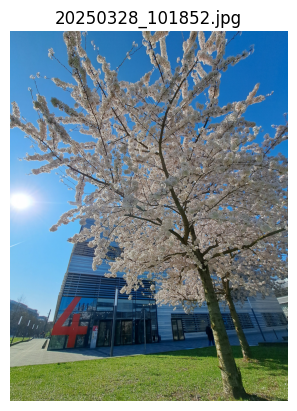

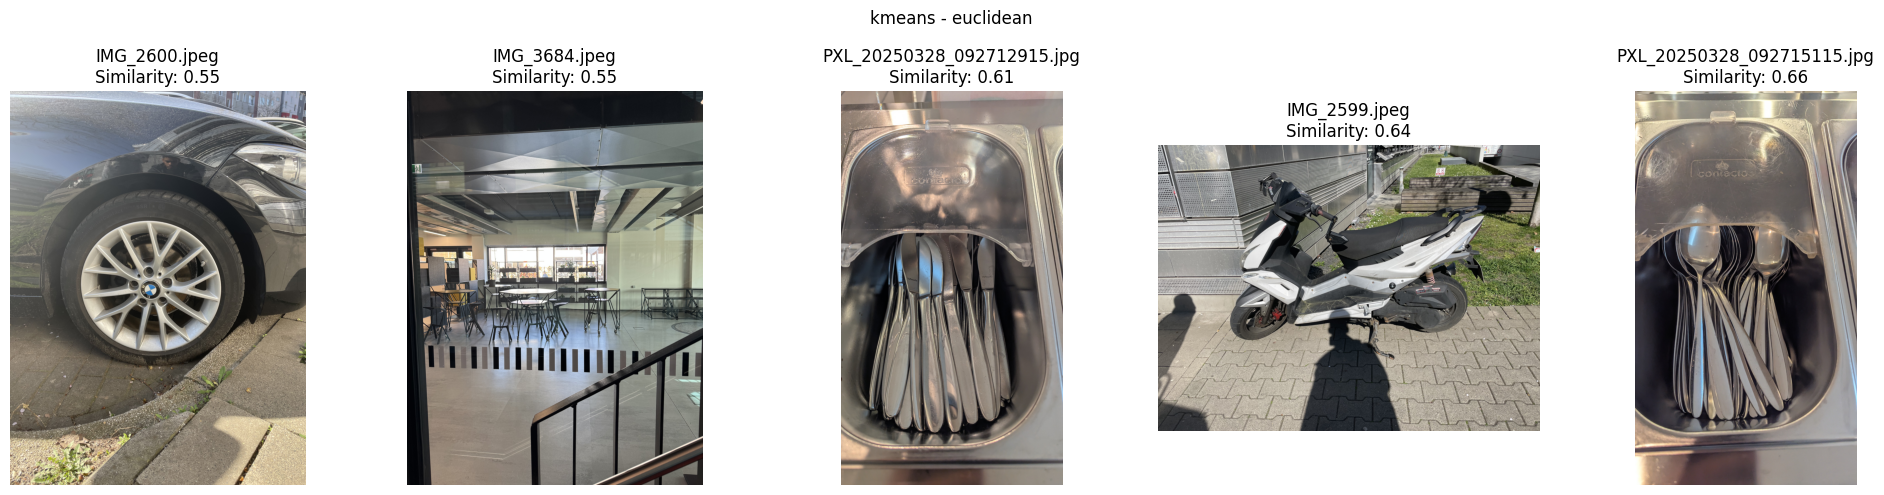

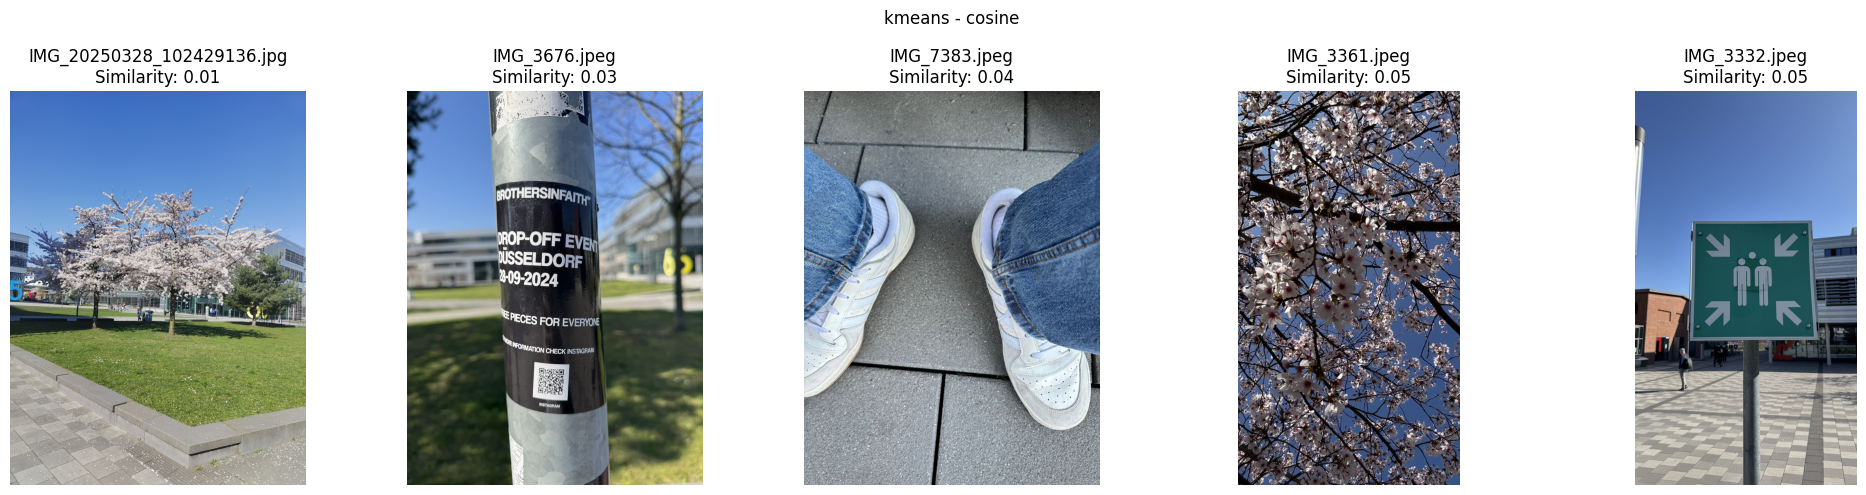

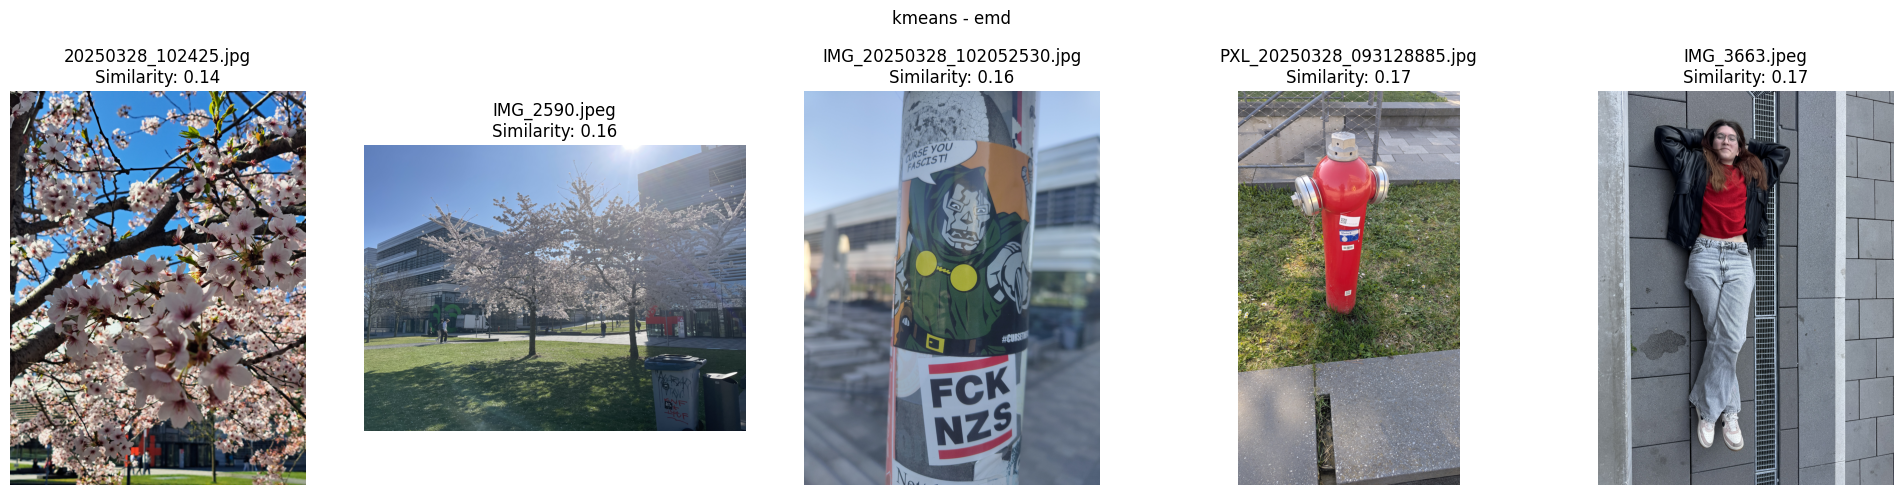

In [7]:
# Compare using different methods
metrics = [
    ('kmeans', 'euclidean'),
    ('kmeans', 'cosine'),
    ('kmeans', 'emd')
]


testing_id = 5

visualizer.display_image(image_processor.images, img_id=testing_id)

for feature_type, metric in metrics:
    comparator = kmeans_comparator if feature_type == 'kmeans' else fingerprint_comparator
    similar_images = comparator.find_similarities(testing_id, metric=metric)
    visualizer.show_similar_images(
        image_processor.images,
        similar_images,
        title=f"{feature_type} - {metric}",
        show_plot=True,
        save_plot=False
    )